In [2]:
# Project paths (booking pipeline)
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
PROJECT_ROOT = REPO_ROOT
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from airline_revenue_analytics.config import get_paths

PATHS = get_paths("booking")
DATA_DIR = REPO_ROOT / "data"
RAW_DIR = PATHS.data_raw
DB_PATH = PATHS.db_path
OUTPUT_DIR = PATHS.outputs_root
FIG_DIR = PATHS.figures
TAB_DIR = PATHS.tables
ART_DIR = PATHS.artifacts

def _rel(p: Path) -> str:
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return Path(p).name

print("REPO_ROOT:", REPO_ROOT.name)
print("DB_PATH:", _rel(DB_PATH))
print("OUTPUT_DIR:", _rel(OUTPUT_DIR))


REPO_ROOT: airline-revenue-analytics
DB_PATH: data/raw/airlines_db.sqlite
OUTPUT_DIR: outputs/booking


# 05 - Modeling Loop B (Steps 5–7, stronger models + iteration)
Goal: train stronger models (regularised linear + boosted tree) on the SAME split,
export metrics/predictions/plots, and compare with Loop A for Step 8.5 evidence.

Outputs:
- `outputs/booking/tables/model_loopB_results.csv`
- `outputs/booking/tables/model_comparison_all.csv`                # Loop A + Loop B
- `outputs/booking/tables/table_7_1_predictions_loopB.csv`
- `outputs/booking/tables/table_5_2_ridge_coefficients_loopB.csv`
- `outputs/booking/figures/figure_7_1_residuals_vs_fitted_loopB.png`
- `outputs/booking/figures/figure_7_1_actual_vs_pred_loopB.png`
- `outputs/booking/artifacts/pipe_ridge_loopB.joblib`
- `outputs/booking/artifacts/pipe_hgbr_loopB.joblib`


In [3]:
# Imports & paths
import sys, pathlib, numpy as np, pandas as pd
import matplotlib; import matplotlib.pyplot as plt

# ensure "src" importable when running from notebooks/
sys.path.append(str(PROJECT_ROOT))


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
# HistGradientBoostingRegressor: enable on very old sklearn
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass
try:
    from sklearn.ensemble import HistGradientBoostingRegressor
    HGBR_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor  # fallback
    HGBR_AVAILABLE = False

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

OUT_DIR = OUTPUT_DIR
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"
ART_DIR = OUT_DIR / "artifacts"

SEED = 42
np.random.seed(SEED)

print("FIG_DIR:", _rel(FIG_DIR))
print("TAB_DIR:", _rel(TAB_DIR))
print("ART_DIR:", _rel(ART_DIR), "| HGBR_AVAILABLE:", HGBR_AVAILABLE)


FIG_DIR: outputs/booking/figures
TAB_DIR: outputs/booking/tables
ART_DIR: outputs/booking/artifacts | HGBR_AVAILABLE: True


/Users/ethan/Documents/GitHub/airline-revenue-analytics/.venv/lib/python3.13/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [5]:
# Load dataset built in 02 and split file produced in 03
df = pd.read_parquet(TAB_DIR / "booking_model_df.parquet")
split_ids = pd.read_csv(TAB_DIR / "table_4_3_1_split_ids.csv")

# Target & features (same as 03/04)
target = "log_total_amount"
num_cols = [
    "n_segments", "sum_sched_duration_min", "avg_sched_duration_min",
    "max_sched_duration_min", "share_premium_cabin", "max_cabin_index",
    "has_longhaul", "n_unique_routes", "avg_booking_lead_days"
]

# ---------- Reconstruct split (use index if present; otherwise map by book_ref) ----------
if "index" in split_ids.columns:
    idx_train = split_ids.loc[split_ids["split"].eq("train"), "index"].to_numpy()
    idx_test  = split_ids.loc[~split_ids["split"].eq("train"), "index"].to_numpy()
else:
    idx_map = df.reset_index()[["index", "book_ref"]]
    merged  = split_ids.merge(idx_map, on="book_ref", how="left", validate="one_to_one")
    idx_train = merged.loc[merged["split"].eq("train"), "index"].to_numpy()
    idx_test  = merged.loc[~merged["split"].eq("train"), "index"].to_numpy()

# Categorical: top-K route mapping (train-only)
cat_raw = df["primary_route_code"].astype("string").fillna("Unknown")
top_k = 20
top_routes = cat_raw.loc[idx_train].value_counts().index[:top_k].tolist()
df["primary_route_code_top"] = np.where(cat_raw.isin(top_routes), cat_raw, "Other")
cat_cols = ["primary_route_code_top"]

# Compose X/y
X_all = df[num_cols + cat_cols].copy()
y_all = df[target].copy()

X_train, y_train = X_all.loc[idx_train], y_all.loc[idx_train]
X_test,  y_test  = X_all.loc[idx_test],  y_all.loc[idx_test]

X_train.shape, X_test.shape

# Convenience aliases (target already log scale)
y_train_log, y_test_log = y_train, y_test


In [6]:
# Build preprocessor (fit later inside each pipeline)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols),
])

pre


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [7]:
# Version-robust evaluation (handles old sklearn without squared=)
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    r2 = float(r2_score(y_true, y_pred))
    try:
        rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mae = float(mean_absolute_error(y_true, y_pred))
    return {"R2": r2, "RMSE": rmse, "MAE": mae}


In [8]:
# Ridge (regularised linear) – modest grid
ridge = Ridge(random_state=SEED)
ridge_grid = {"model__alpha": np.logspace(-3, 3, 13)}

pipe_ridge = Pipeline([("pre", pre), ("model", ridge)])
gs_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=ridge_grid,
    scoring="neg_root_mean_squared_error",  # works if supported; fallback handled below
    cv=3,
    n_jobs=1,
    refit=True
)
try:
    gs_ridge.fit(X_train, y_train)
except ValueError:
    # Older sklearn may not have neg_root_mean_squared_error; fallback to neg_mean_squared_error
    gs_ridge = GridSearchCV(
        estimator=pipe_ridge,
        param_grid=ridge_grid,
        scoring="neg_mean_squared_error",
        cv=3,
        n_jobs=1,
        refit=True
    )
    gs_ridge.fit(X_train, y_train)

best_ridge = gs_ridge.best_estimator_
pred_ridge = best_ridge.predict(X_test)
m_ridge = {"model": "Ridge"} | evaluate(y_test, pred_ridge)
m_ridge["alpha"] = float(gs_ridge.best_params_["model__alpha"])

# Export coefficients (post-OHE feature names from TRAIN)
ohe_train = best_ridge.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
feat_names = num_cols + list(ohe_train.get_feature_names_out(cat_cols))
coefs = best_ridge.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).to_csv(TAB_DIR/"table_5_2_ridge_coefficients_loopB.csv", index=False)

# Save artifact
joblib.dump(best_ridge, ART_DIR/"pipe_ridge_loopB.joblib")

m_ridge, coef_df.head(8)


({'model': 'Ridge',
  'R2': 0.7890438058044307,
  'RMSE': 0.39891118358511546,
  'MAE': 0.28656125612626576,
  'alpha': 3.1622776601683795},
                   feature      coef  abs_coef
 0              n_segments  0.414675  0.414675
 1  sum_sched_duration_min  0.037633  0.037633
 2  avg_sched_duration_min  0.103820  0.103820
 3  max_sched_duration_min  0.609308  0.609308
 4     share_premium_cabin  0.101119  0.101119
 5         max_cabin_index  0.146497  0.146497
 6            has_longhaul -0.153087  0.153087
 7         n_unique_routes -0.077934  0.077934)

In [9]:
if HGBR_AVAILABLE:
    gbr = HistGradientBoostingRegressor(
        random_state=SEED,
        max_depth=None,
        max_leaf_nodes=31,
        learning_rate=0.1,
        min_samples_leaf=20
    )
    param_grid = {
        "model__max_leaf_nodes": [31, 63],
        "model__learning_rate": [0.05, 0.1],
        "model__min_samples_leaf": [10, 20, 40],
    }
else:
    # Fallback to classic GradientBoostingRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    gbr = GradientBoostingRegressor(
        random_state=SEED,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=3
    )
    param_grid = {
        "model__learning_rate": [0.05, 0.1],
        "model__n_estimators": [200, 300, 500],
        "model__max_depth": [2, 3],
    }

pipe_gbr = Pipeline([("pre", pre), ("model", gbr)])
gs_gbr = GridSearchCV(
    estimator=pipe_gbr,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # use MSE for broad compatibility
    cv=3,
    n_jobs=1,
    refit=True
)
gs_gbr.fit(X_train, y_train)

best_gbr = gs_gbr.best_estimator_
pipe_hgb = best_gbr
pred_gbr = best_gbr.predict(X_test)
m_gbr = {"model": "HistGBR" if HGBR_AVAILABLE else "GBR"} | evaluate(y_test, pred_gbr)
m_gbr["best_params"] = str(gs_gbr.best_params_)

# Save artifact
joblib.dump(best_gbr, ART_DIR/"pipe_hgbr_loopB.joblib")

m_gbr


{'model': 'HistGBR',
 'R2': 0.9227315343098988,
 'RMSE': 0.2414244303888701,
 'MAE': 0.12442618528258582,
 'best_params': "{'model__learning_rate': 0.1, 'model__max_leaf_nodes': 63, 'model__min_samples_leaf': 10}"}

In [10]:
# Loop B results table
loopB_results = pd.DataFrame([m_ridge, m_gbr]).sort_values("RMSE")
loopB_results.to_csv(TAB_DIR/"model_loopB_results.csv", index=False)

# Combine with Loop A (if file exists)
try:
    loopA = pd.read_csv(TAB_DIR/"model_baselines_loopA.csv")
    cmp_all = pd.concat([loopA.assign(loop="A"), loopB_results.assign(loop="B")], ignore_index=True)
    cmp_all.sort_values(["RMSE","loop"]).to_csv(TAB_DIR/"model_comparison_all.csv", index=False)
    cmp_all
except FileNotFoundError:
    print("Loop A metrics not found; only Loop B results are saved.")
    loopB_results


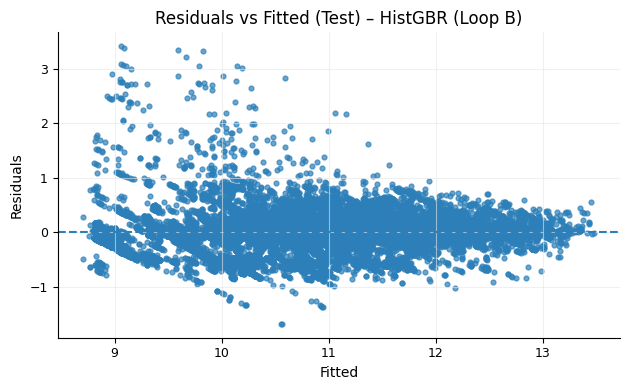

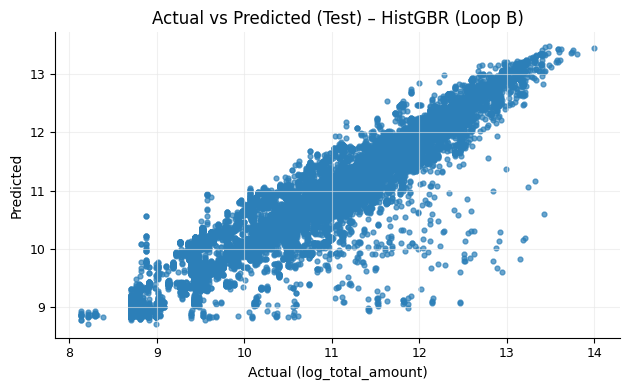

('HistGBR',
      model        R2      RMSE       MAE     alpha  \
 1  HistGBR  0.922732  0.241424  0.124426       NaN   
 0    Ridge  0.789044  0.398911  0.286561  3.162278   
 
                                          best_params  
 1  {'model__learning_rate': 0.1, 'model__max_leaf...  
 0                                                NaN  )

In [11]:
# Pick the best model within Loop B
bestB = m_ridge if m_ridge["RMSE"] <= m_gbr["RMSE"] else m_gbr
best_name = bestB["model"]
best_pipe = best_ridge if best_name == "Ridge" else best_gbr
best_pred = pred_ridge if best_name == "Ridge" else pred_gbr

# Residuals vs Fitted
resid = y_test - best_pred
plt.figure()
plt.scatter(best_pred, resid, s=12, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.title(f"Residuals vs Fitted (Test) – {best_name} (Loop B)")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_7_1_residuals_vs_fitted_loopB.png", dpi=150)
plt.show()

# Actual vs Predicted
plt.figure()
plt.scatter(y_test, best_pred, s=12, alpha=0.7)
plt.title(f"Actual vs Predicted (Test) – {best_name} (Loop B)")
plt.xlabel("Actual (log_total_amount)"); plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_7_1_actual_vs_pred_loopB.png", dpi=150)
plt.show()

# Save per-row predictions (evidence)
pred_df = pd.DataFrame({
    "index": X_test.index,
    "book_ref": df.loc[X_test.index, "book_ref"].values,
    "y_true": y_test.values,
    f"y_pred_{best_name}_loopB": best_pred
})
pred_df.to_csv(TAB_DIR/"table_7_1_predictions_loopB.csv", index=False)

best_name, loopB_results.sort_values("RMSE")


**Summary (Loop B):**
- Trained stronger models (Ridge + HistGBR/GBR) on the SAME split as Loop A.
- Exported metrics & predictions; produced residual plots; dumped fitted pipelines.
- Wrote `model_comparison_all.csv` for Step 8.5 (iteration) comparison.

**Next:** open `06_interpretation_compare.ipynb` for Step 8:
- compare Loop A vs Loop B (tables/plots),
- discuss business interpretation and next actions,
- optionally add error-by-segment/cabin/route buckets for insights.


In [12]:
# ---- 7.2 / Table XV: RUB errors for HistGBR (champion) ----
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_score(y_true, y_pred):
    try:
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def backtransform_with_lognormal_correction(pipeline, X_tr, y_tr_log, X_te):
    yhat_tr_log = pipeline.predict(X_tr)
    sigma2 = np.mean((y_tr_log - yhat_tr_log)**2)
    yhat_te_log = pipeline.predict(X_te)
    return np.exp(yhat_te_log + 0.5 * sigma2)

y_test_rub = np.exp(y_test_log)
yhat_rub = backtransform_with_lognormal_correction(pipe_hgb, X_train, y_train_log, X_test)
rub_row = pd.DataFrame([[
    "HistGradientBoosting (Loop B)",
    rmse_score(y_test_rub, yhat_rub),
    mean_absolute_error(y_test_rub, yhat_rub),
    float(np.median(np.abs(y_test_rub - yhat_rub)))
]], columns=["Model","RMSE_RUB","MAE_RUB","Median_AE_RUB"])

# Append/merge with Loop A RUB table
path_a = TAB_DIR/"table_7_2_RUB_errors_loopA.csv"
rub_all = pd.concat([pd.read_csv(path_a), rub_row], ignore_index=True) if path_a.exists() else rub_row
rub_all.to_csv(TAB_DIR/"table_7_2_RUB_errors_all.csv", index=False)
rub_all


,Model,RMSE_RUB,MAE_RUB,Median_AE_RUB
0,Linear (Loop A),80445.832095,26637.059794,10048.909619
1,Decision Tree (Loop A),32037.594211,17033.734073,9293.760295
2,HistGradientBoosting (Loop B),22059.671819,9357.685242,3190.392889


In [13]:
# ---- 8.2.1: Test-set permutation importance for HistGBR ----
from sklearn.inspection import permutation_importance

pre = pipe_hgb.named_steps.get("pre", pipe_hgb.named_steps.get("preprocessor"))
feat_names = getattr(pre, "get_feature_names_out", lambda: np.array([]))().tolist()
r = permutation_importance(pipe_hgb, X_test, y_test_log, n_repeats=5, random_state=42, scoring="r2")

# Fallback to generic names if transformer cannot provide names
if len(feat_names) != len(r.importances_mean):
    feat_names = [f"f{i}" for i in range(len(r.importances_mean))]

pi = (pd.DataFrame({"feature": feat_names, "importance_mean": r.importances_mean, "importance_std": r.importances_std})
        .sort_values("importance_mean", ascending=False))
pi.to_csv(TAB_DIR/"table_8_2_1_histgbr_permutation_importance.csv", index=False)
pi.head(20)


,feature,importance_mean,importance_std
1,f1,1.265241,0.005408
3,f3,0.193457,0.001118
7,f7,0.160440,0.000421
2,f2,0.090839,0.000304
4,f4,0.082663,0.000506
5,f5,0.020421,0.000268
9,f9,0.014333,0.000249
0,f0,0.014261,0.000323
8,f8,0.002133,0.000269
6,f6,0.000000,0.000000


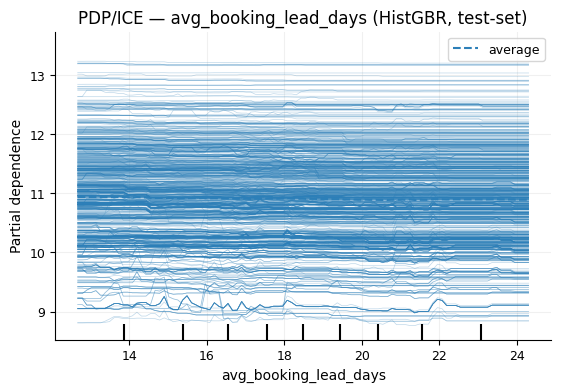

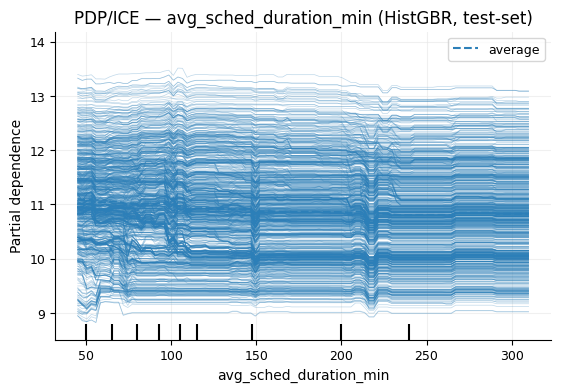

/Users/ethan/Documents/GitHub/airline-revenue-analytics/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:721: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


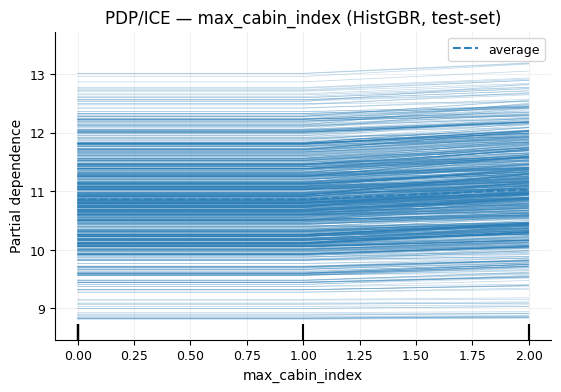

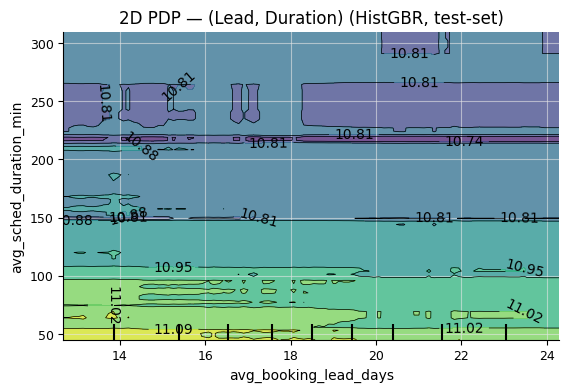

In [14]:
# ---- 8.2.2: PDP/ICE for Lead, Duration, Cabin Index; 2-D PDP for (Lead, Duration) ----
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

one_d = [("avg_booking_lead_days",), ("avg_sched_duration_min",), ("max_cabin_index",)]
for f in one_d:
    PartialDependenceDisplay.from_estimator(pipe_hgb, X_test, [f], kind="both")
    plt.title(f"PDP/ICE — {f[0]} (HistGBR, test-set)")
    plt.show()

PartialDependenceDisplay.from_estimator(pipe_hgb, X_test,
    [("avg_booking_lead_days", "avg_sched_duration_min")])
plt.title("2D PDP — (Lead, Duration) (HistGBR, test-set)")
plt.show()
